In [1]:
import sys
sys.path.append("../../src")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Load and preprocess data

In [4]:
import data

In [5]:
# set db path hackily
data._get_connection("../../data/participants.db")

raw_df = data.get_trials_df(data.load_raw_results(),
                            ("experiment_id", "materials_id", "item_id", "condition_id",
                             "practice_sentence"))

response_df = raw_df[(raw_df.experiment_id == "02_acceptability_swarm") & (raw_df.trial_type == "html-slider-response-with-copout")] \
    .reset_index().set_index(["uniqueid", "trial_index"])

Missing datastring for uid A33LYSCQQU1YDJ:31JLPPHS2VIHTNHTYQX3Y0LM83NO3X. Status was 1.
Missing datastring for uid AT6ICEVY8RM8D:3WS1NTTKEZ0R6I53G0WU98E1D1J0FL. Status was 1.


In [6]:
# Expand condition labels, which are tuples
response_df = pd.concat([response_df, response_df.condition_id.apply(pd.Series).rename(columns=lambda x: f"condition_{x}")], axis=1) \
    .drop(columns="condition_id")

In [7]:
# Convert condition_id to independent features
response_df["agent_is_subject"] = response_df["condition_1"] == 1

In [8]:
# Norm slider values within-subject.
response_df["slider_zscore"] = \
    response_df.groupby("uniqueid").slider_value.apply(lambda xs: (xs - xs.mean()) / (xs.std(ddof=0)))

In [9]:
# dtype fixes
response_df["dateTime"] = pd.to_datetime(response_df.dateTime, unit="ms")

In [10]:
response_df.head()

condition  \
uniqueid                                     trial_index              
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3                    0   
                                             4                    0   
                                             5                    0   
                                             7                    0   
                                             8                    0   

                                                          counterbalance  \
uniqueid                                     trial_index                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3                         0   
                                             4                         0   
                                             5                         0   
                                             7                         0   
                                             8                         0   

                                                                            assignmentId  \
uniqueid                                     trial_index                                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             4            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             5            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             7            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             8            30LSNF239VJICJA7WV6TVTK8QRV2IY   

                                                               workerId  \
uniqueid                                     trial_index                  
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            AUZNL6ARA1UEC   
                                             4            AUZNL6ARA1UEC   
                                             5            AUZNL6ARA1UEC   
                                             7            AUZNL6ARA1UEC   
                                             8            AUZNL6ARA1UEC   

                                                                                   hitId  \
uniqueid                                     trial_index                                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             4            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             5            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             7            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             8            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   

                                                                                trial_type  \
uniqueid                                     trial_index                                     
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            html-slider-response-with-copout   
                                             4            html-slider-response-with-copout   
                                             5            html-slider-response-with-copout   
                                             7            html-slider-response-with-copout   
                                             8            html-slider-response-with-copout   

                                                               rt  \
uniqueid                                     trial_index            
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            10886.3   
                                             4             9561.1   
                                             5             4337.5   
                                             7             6262.3   
                                             8             7395.1   

                                                         internal_no

In [11]:
response_df.to_csv("raw_responses.csv")

## Preliminaries

### How are people using the sliders?

- Stripplot points correspond to individual slider responses.
- Responses are grouped horizontally by subject.
- Transparent boxplots indicate filler response value for a particular subject. Red median lines / boxes indicate "good" fillers and blue indicate "bad."

<AxesSubplot:xlabel='uniqueid', ylabel='slider_value'>

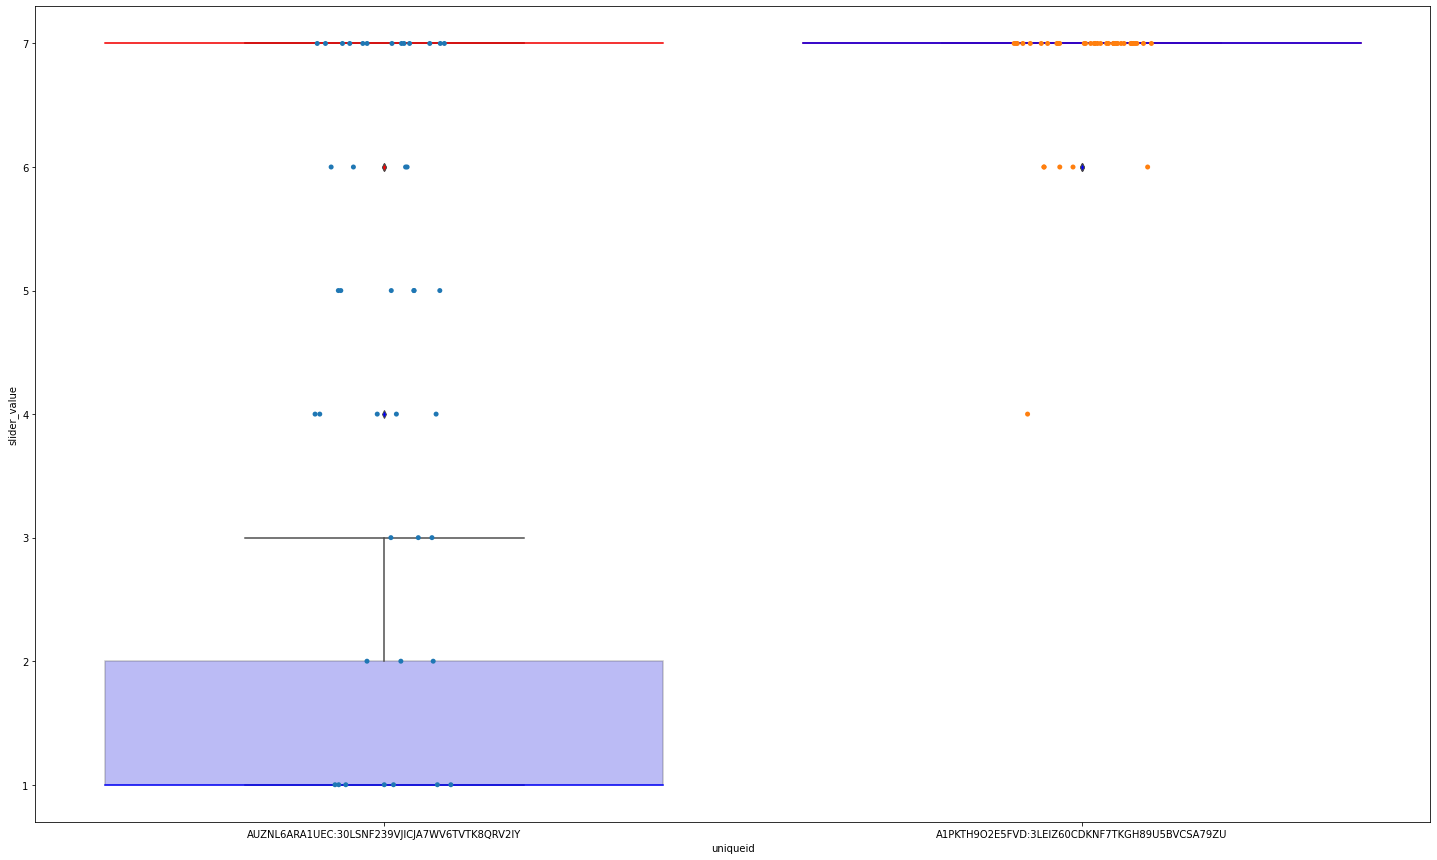

In [12]:
# Order S by descending difference between mean full-filler and empty-filler rating
filler_rows = response_df[response_df.condition_0 == "filler"]
filler_diffs = filler_rows.groupby("uniqueid").apply(
    lambda xs: xs[xs.condition_1 == "good"].slider_value.mean() - xs[xs.condition_1 == "bad"].slider_value.mean())
subject_order = filler_diffs.sort_values(ascending=False).index

plt.subplots(figsize=(25, 15))
g = sns.stripplot(data=response_df.reset_index(), x="uniqueid", y="slider_value", order=subject_order)

# plot filler responses
sns.boxplot(data=response_df[(response_df.condition_0 == "filler") & (response_df.condition_1 == "good")].reset_index(),
            x="uniqueid", y="slider_value", order=subject_order,
            color="red", medianprops=dict(color="red"), flierprops=dict(markerfacecolor="red"), boxprops=dict(alpha=0.3))
sns.boxplot(data=response_df[(response_df.condition_0 == "filler") & (response_df.condition_1 == "bad")].reset_index(),
            x="uniqueid", y="slider_value", order=subject_order, 
            color="blue", medianprops=dict(color="blue"), flierprops=dict(markerfacecolor="blue"), boxprops=dict(alpha=0.3))

## Attention checks

### Practice round

In [13]:
def compute_practice_success(subj_rows):
    """
    Compute fraction of practice sentences for which response equals
    ground truth.
    """
    practice_rows = subj_rows[~subj_rows.practice_sentence.isna()]
    practice_rows[["practice_rating", "practice_idx"]] = practice_rows.practice_sentence.str.split("-", 1, expand=True)
    success = practice_rows["practice_rating"].astype(int) == practice_rows["slider_value"]
    return success.mean()
    
practice_attention_failures = response_df.groupby("uniqueid").apply(compute_practice_success)
practice_attention_failures = practice_attention_failures[practice_attention_failures < 1]
practice_attention_failures

uniqueid
A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU    0.666667
dtype: float64

### Fillers

<AxesSubplot:xlabel='t'>

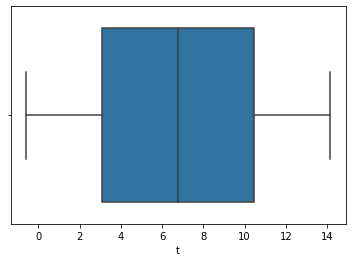

In [14]:
from scipy.stats import ttest_ind
def compute_filler_ttest(subj_rows):
    """
    sanity check: "good" items should be rated higher than "bad" filler items
    """
    filler_rows = subj_rows[subj_rows.condition_0 == "filler"]
    
    good_filler = filler_rows[filler_rows.condition_1 == "good"]
    bad_filler = filler_rows[filler_rows.condition_1 == "bad"]
    
    return pd.Series(ttest_ind(good_filler.slider_value, bad_filler.slider_value),
                     index=["t", "pval"])

filler_stats = response_df.groupby("uniqueid").apply(compute_filler_ttest)
sns.boxplot(data=filler_stats.reset_index(), x="t", hue="uniqueid")

In [15]:
filler_stats.sort_values("t")

,t,pval
uniqueid,,
A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU,-0.600000,5.559852e-01
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY,14.144855,3.427774e-11


## Final data processing

In [16]:
exp_items = response_df[response_df.practice_sentence.isna()]

### Filter based on practice and attention checks

In [17]:
practice_drops = practice_attention_failures[practice_attention_failures < 1]
drop_pct = np.round(len(practice_drops) / len(practice_attention_failures.index) * 100 if len(practice_attention_failures) > 0 else 0, 1)
print(f"{len(practice_drops)} subjects ({drop_pct}%) disqualified and dropped due to failed practice.")
print("\t" + "\n\t".join(practice_drops.index))
exp_items = exp_items.drop(practice_drops.index, level="uniqueid")

attention_drops = filler_stats[(filler_stats.t < 0) | (filler_stats.pval > 1e-1) | filler_stats.t.isna()]
drop_pct = np.round(len(attention_drops) / len(filler_stats.index) * 100, 1)
print(f"{len(attention_drops)} subjects ({drop_pct}%, possibly overlapping with previous) disqualified and dropped due to failed attention checks.")
print("\t" + "\n\t".join(attention_drops.index))
exp_items = exp_items.drop(attention_drops.index, level="uniqueid")

1 subjects (100.0%) disqualified and dropped due to failed practice.
	A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU
1 subjects (50.0%, possibly overlapping with previous) disqualified and dropped due to failed attention checks.
	A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU


In [18]:
print(f"{len(set(exp_items.index.get_level_values('uniqueid')))} subjects remaining.")

1 subjects remaining.


### Merge in materials

In [19]:
import json
def load_materials(mat):
    with open(f"../../materials/{mat}.json") as f:
        materials = json.load(f)
    return pd.DataFrame.from_records(materials["items"]).rename(columns={"id": "item_id"}).set_index("item_id")

materials_ids = sorted(set(exp_items.materials_id))
materials_df = pd.concat([load_materials(mat) for mat in materials_ids], names=["materials_id"], keys=materials_ids, axis=0)

materials_df["AV"] = materials_df.A.str.cat(materials_df.V, " ")

# NB this doesn't handle fillers correctly

In [20]:
keep_cols = ["A", "V", "L", "AV", "A concrete?", "A countable?"]
merged_df = pd.merge(exp_items, materials_df[keep_cols], left_on=["materials_id", "item_id"], right_index=True)

### Export

In [21]:
merged_df.to_csv("merged_df.csv")

## Analysis

In [22]:
def test_within_subject(rows):
    baseline = rows[(rows.condition_0 == "filler") & (rows.condition_1 == "bad")].slider_value
    critical_rows = rows[~(rows.condition_0 == "filler")].set_index("agent_is_subject").slider_value
    
    location_t, location_pval = ttest_ind(critical_rows.loc[False], baseline)
    agent_t, agent_pval = ttest_ind(critical_rows.loc[True], baseline)
    return pd.Series({"location_t": location_t, "location_pval": location_pval,
                      "agent_t": agent_t, "agent_pval": agent_pval})
merged_df.groupby("uniqueid").apply(test_within_subject)

,location_t,location_pval,agent_t,agent_pval
uniqueid,,,,
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY,5.457596,0.000018,7.432184,0.000008
